In [1]:
import sys
sys.path.append('/mnt/azmnt/code/Users/')

import numba
import pandas as pd
import numpy as np
from numpy import array
import math
from timeit import default_timer as timer
from datetime import datetime, timedelta
import numba
from scipy import stats
from processing_constants import ALL_CONTINUOUS_COLUMNS, HIGH_NAN_COLUMNS, WHOLE_MARKET_COLUMNS
from processing_constants import BOLLINGER_PREDICTION_COLUMNS, BOLLINGER_VALUE_COLUMNS
from optimise_dataframe import optimise_df
import glob
from sklearn import preprocessing
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier, VotingClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib
import matplotlib.pyplot as plt



/Users/neilkloot/anaconda/lib/python3.6/site-packages/numba/errors.py:131: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
train_data = pd.read_pickle(
    'data/ml-ta-discretised-training-data-201908262001.pkl.gz', compression='gzip')



In [3]:
# Add week date as a timestamp
train_data['weekts'] = pd.DatetimeIndex(train_data['week_starting']).asi8


In [4]:
train_data.memory_usage().sum()

9629345240

In [5]:
train_data = optimise_df(train_data)

In [6]:
train_data.memory_usage().sum()

4428306402

In [7]:
bin_names = ['strong_sell', 'sell', 'hold', 'buy', 'strong_buy']

# Use full training set (proportion 1)
print('Setting target dfs')
train_target_oh = train_data[bin_names]
train_target_le = train_data['class_index']
print('Setting symbol df')
train_symbols = train_data['symbol']

cols_to_drop = bin_names.copy()
cols_to_drop.extend(['symbol', 'target', 'class', 'class_index', 'week_starting'])

print('Dropping cols')
train_data.drop(cols_to_drop, axis=1, inplace=True, errors='ignore')

print('Training data memory', train_data.memory_usage().sum())

Setting target dfs
Setting symbol df
Dropping cols
Training data memory 4403374397


In [8]:
train_data.shape


(1079523, 1106)

In [9]:
from sklearn.cluster import FeatureAgglomeration 

agg_model_third = FeatureAgglomeration(n_clusters=int(train_data.shape[1] / 3))

agg_model_third.fit(train_data)


FeatureAgglomeration(affinity='euclidean', compute_full_tree='auto',
                     connectivity=None, distance_threshold=None, linkage='ward',
                     memory=None, n_clusters=368,
                     pooling_func=<function mean at 0x1157e4400>)

In [11]:
# Split data for test by 50%
train_samples = int(train_data.shape[0] * 0.75)
test_samples = train_data.shape[0] - train_samples

sample_train_data = agg_model_third.transform(train_data.head(train_samples))
sample_train_target_le = train_target_le.head(train_samples)

sample_test_data = agg_model_third.transform(train_data.tail(test_samples))
sample_test_target_le = train_target_le.tail(test_samples)

del train_data
del train_target_le


In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def plot_confusion_matrix(cm, labels, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def predict_values(clf, X):
    print('Executing predictions')
    pred_y = clf.predict(X)
    return pred_y

def evaluate_classifier(test_y, pred_y, bin_names):
    print('Scoring classifier')
    score = accuracy_score(test_y, pred_y)

    print('Accuracy:', score)

    # Compute confusion matrix
    cm = confusion_matrix(test_y, pred_y)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)
    plt.figure()
    plot_confusion_matrix(cm, bin_names, title='Confusion matrix for classifier')

    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix for classifier')
    print(cm_normalized)
    plt.figure()
    plot_confusion_matrix(cm_normalized, bin_names, title='Normalized confusion matrix for classifier')

    print('-'*20)
    


--------------------------------------------------
Fitting random forest model
--------------------------------------------------
Saving model
Random forest model done
Scoring classifier
Accuracy: 0.44286555926500937
Confusion matrix, without normalization
[[23100  6744  9815 10096  6248]
 [ 9578 21773  8155  5780  6772]
 [10140  3575 17511 10014 14133]
 [ 9530  2109  6898 24914 11110]
 [ 2562  1317  6942  8842 32223]]
Normalized confusion matrix for classifier
[[0.41 0.12 0.18 0.18 0.11]
 [0.18 0.42 0.16 0.11 0.13]
 [0.18 0.06 0.32 0.18 0.26]
 [0.17 0.04 0.13 0.46 0.2 ]
 [0.05 0.03 0.13 0.17 0.62]]
--------------------


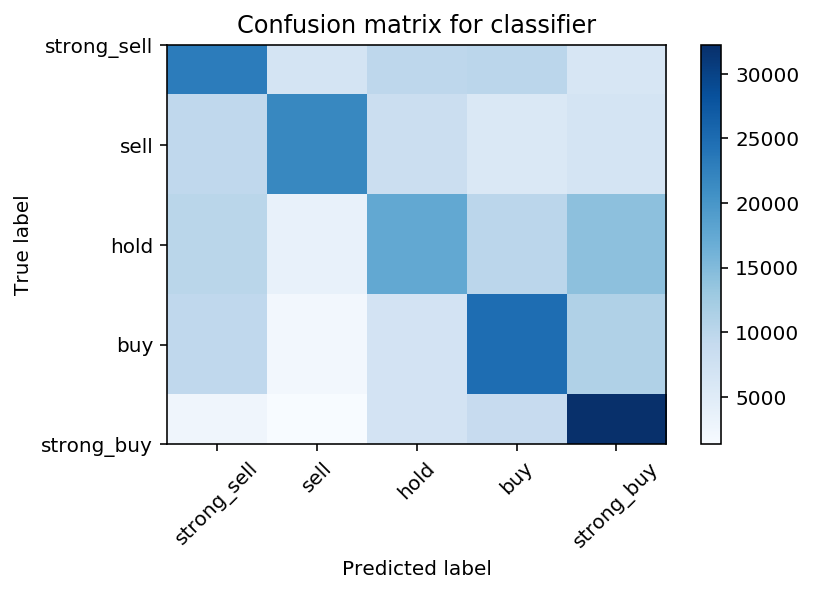

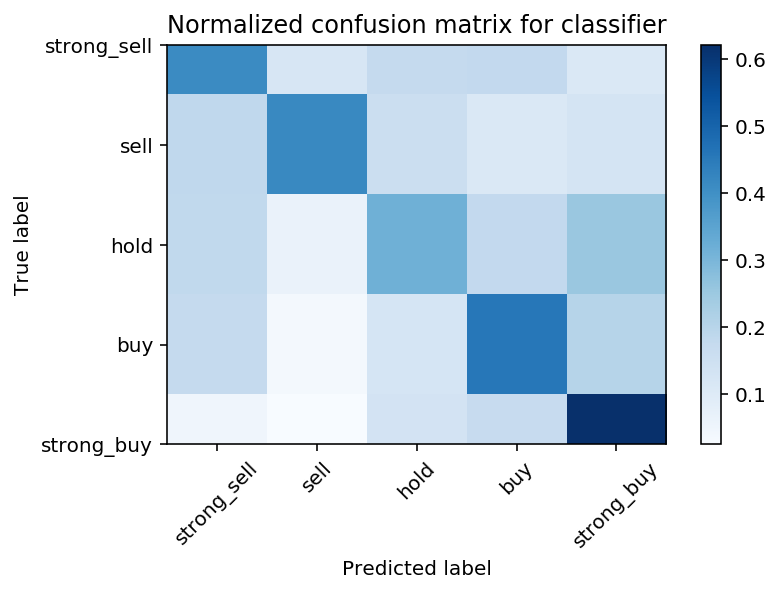

In [13]:
# Random forest model
random_forest_model = RandomForestClassifier(
    max_depth=20, 
    n_estimators=505, 
    min_samples_split=2, 
    min_samples_leaf=1
)

print('-' * 50)
print('Fitting random forest model')
random_forest_model.fit(sample_train_data, sample_train_target_le)
print('-' * 50)
print('Saving model')
joblib.dump(random_forest_model, 'models/random-forest-model.joblib.z')
print('Random forest model done')

train_pred_y = random_forest_model.predict(sample_test_data)
evaluate_classifier(sample_test_target_le.values, train_pred_y, bin_names)


------------------------- Training MLP -------------------------
Iteration 1, loss = inf
Iteration 2, loss = inf
Iteration 3, loss = inf
Iteration 4, loss = inf
Iteration 5, loss = inf
Iteration 6, loss = inf
Iteration 7, loss = inf
Iteration 8, loss = inf
Iteration 9, loss = inf
Iteration 10, loss = inf
Iteration 11, loss = inf
Iteration 12, loss = inf
Iteration 13, loss = inf
Iteration 14, loss = inf
Iteration 15, loss = inf
Iteration 16, loss = inf
Iteration 17, loss = inf
Iteration 18, loss = inf
Iteration 19, loss = inf
Iteration 20, loss = inf
Iteration 21, loss = inf
Iteration 22, loss = inf
Iteration 23, loss = inf
Iteration 24, loss = inf
Iteration 25, loss = inf
Iteration 26, loss = inf
Iteration 27, loss = inf
Iteration 28, loss = inf
Iteration 29, loss = inf
Iteration 30, loss = inf
Iteration 31, loss = inf
Iteration 32, loss = inf
Iteration 33, loss = inf
Iteration 34, loss = inf
Iteration 35, loss = inf
Iteration 36, loss = inf
Iteration 37, loss = inf
Iteration 38, loss 

Iteration 318, loss = inf
Iteration 319, loss = inf
Iteration 320, loss = inf
Iteration 321, loss = inf
Iteration 322, loss = inf
Iteration 323, loss = inf
Iteration 324, loss = inf
Iteration 325, loss = inf
Iteration 326, loss = inf
Iteration 327, loss = inf
Iteration 328, loss = inf
Iteration 329, loss = inf
Iteration 330, loss = inf
Iteration 331, loss = inf
Iteration 332, loss = inf
Iteration 333, loss = inf
Iteration 334, loss = inf
Iteration 335, loss = inf
Iteration 336, loss = inf
Iteration 337, loss = inf
Iteration 338, loss = inf
Iteration 339, loss = inf
Iteration 340, loss = inf
Iteration 341, loss = inf
Iteration 342, loss = inf
Iteration 343, loss = inf
Iteration 344, loss = inf
Iteration 345, loss = inf
Iteration 346, loss = inf
Iteration 347, loss = inf
Iteration 348, loss = inf
Iteration 349, loss = inf
Iteration 350, loss = inf
Iteration 351, loss = inf
Iteration 352, loss = inf
Iteration 353, loss = inf
Iteration 354, loss = inf
Iteration 355, loss = inf
Iteration 35

/Users/neilkloot/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


------------------------- Predicting MLP -------------------------
Scoring classifier
Accuracy: 0.1871083922173106
Confusion matrix, without normalization
[[25267  1258   132   216 29130]
 [24266   986   121   219 26466]
 [27169   949    92   206 26957]
 [24410  1097   101   301 28652]
 [26895   776    57   307 23851]]
Normalized confusion matrix for classifier
[[0.45 0.02 0.   0.   0.52]
 [0.47 0.02 0.   0.   0.51]
 [0.49 0.02 0.   0.   0.49]
 [0.45 0.02 0.   0.01 0.53]
 [0.52 0.01 0.   0.01 0.46]]
--------------------
------------------------- Training SAG -------------------------


ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

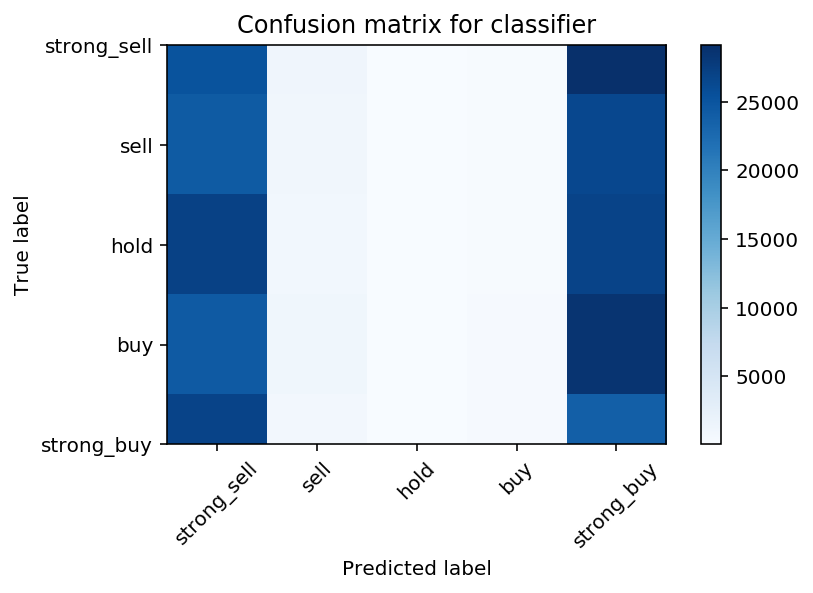

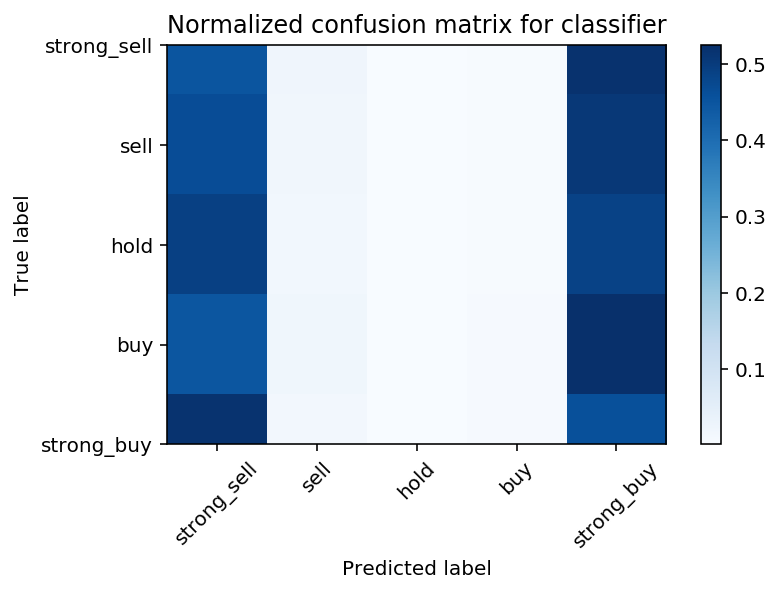

In [23]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

classifiers = [
    ("MLP", MLPClassifier(max_iter=10000, learning_rate_init=0.01, learning_rate='adaptive', tol=1e-4, verbose=1)),
    ("SAG", LogisticRegression(solver='saga', penalty='elasticnet', tol=1e-1, C=1.e4 / sample_train_data.shape[0],
                               multi_class='multinomial', verbose=1))
]


for name, clf in classifiers:
    print("-"*25, "Training", name, "-"*25)
    clf.fit(sample_train_data, sample_train_target_le)
    print("-"*25, "Predicting", name, "-"*25)
    train_pred_y = clf.predict(sample_test_data)
    evaluate_classifier(sample_test_target_le.values, train_pred_y, bin_names)



--------------------------------------------------
Fitting adaboost model
--------------------------------------------------
Saving model
Adaboost model done


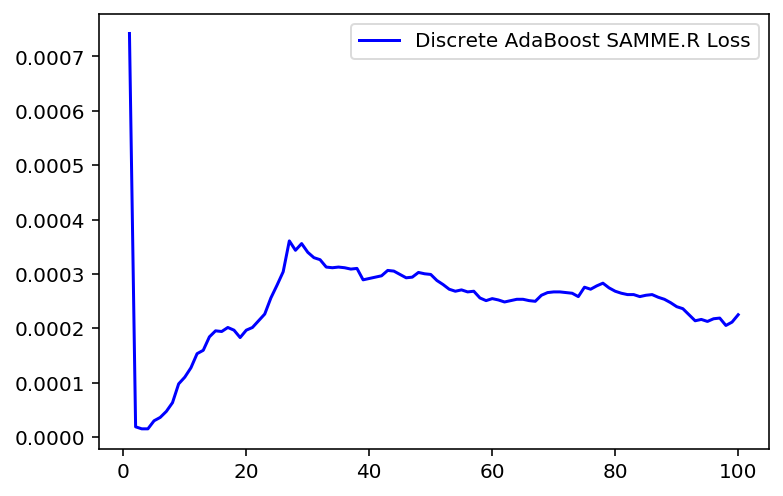

Scoring classifier
Accuracy: 0.4309047320856229
Confusion matrix, without normalization
[[24000  7856 10158  8485  5504]
 [10106 22087  8632  5171  6062]
 [11147  4788 18719  8286 12433]
 [11527  2778  8420 21831 10005]
 [ 3372  1643  9465  7750 29656]]
Normalized confusion matrix for classifier
[[0.43 0.14 0.18 0.15 0.1 ]
 [0.19 0.42 0.17 0.1  0.12]
 [0.2  0.09 0.34 0.15 0.22]
 [0.21 0.05 0.15 0.4  0.18]
 [0.06 0.03 0.18 0.15 0.57]]
--------------------


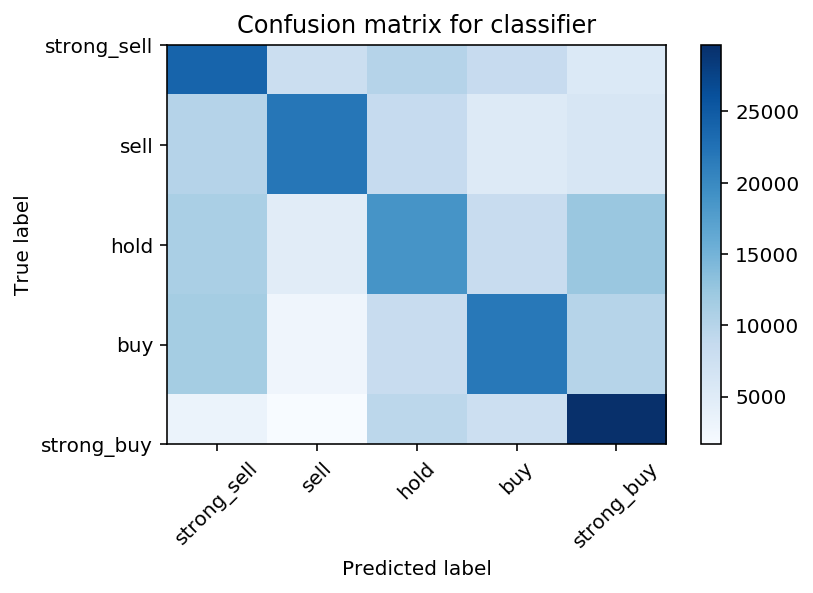

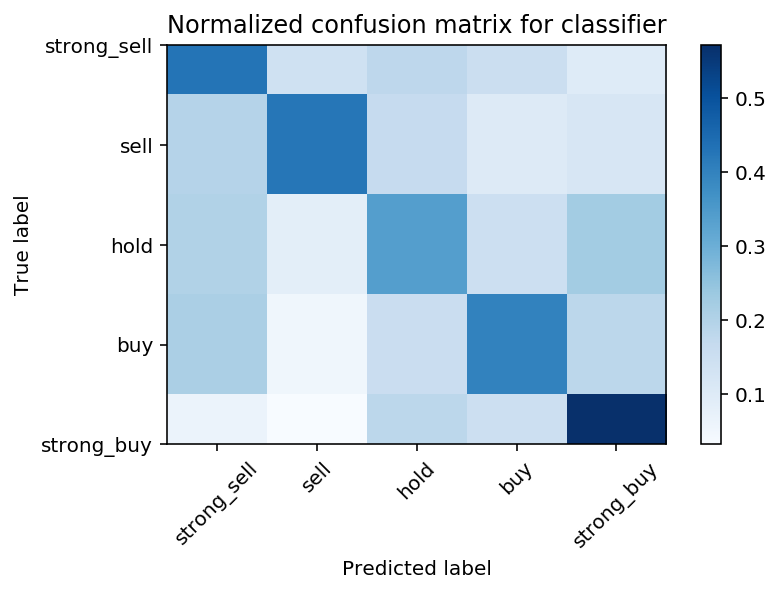

In [17]:
from sklearn.metrics import zero_one_loss

#Adaboost
adaboost_model = AdaBoostClassifier(
    RandomForestClassifier(
        n_estimators=50, 
    ), 
    n_estimators=10,
    algorithm='SAMME.R'
)

print('-' * 50)
print('Fitting adaboost model')
adaboost_model.fit(sample_train_data, sample_train_target_le)
print('-' * 50)
print('Saving model')
joblib.dump(adaboost_model, 'models/adaboost-model-1.joblib.z')
print('Adaboost model done')

fig = plt.figure()

ada_discrete_err_train = np.zeros((adaboost_model.n_estimators,))
for i, y_pred in enumerate(adaboost_model.staged_predict(sample_train_data)):
    ada_discrete_err_train[i] =  zero_one_loss(y_pred, sample_train_target_le.values)
    
plt.plot(np.arange(adaboost_model.n_estimators) + 1, ada_discrete_err_train,
        label='Discrete AdaBoost SAMME.R Loss',
        color='blue')

leg = plt.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()

train_pred_y = adaboost_model.predict(sample_test_data)
evaluate_classifier(sample_test_target_le.values, train_pred_y, bin_names)


--------------------------------------------------
Fitting adaboost model


/Users/neilkloot/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--------------------------------------------------
Saving model
Adaboost model done


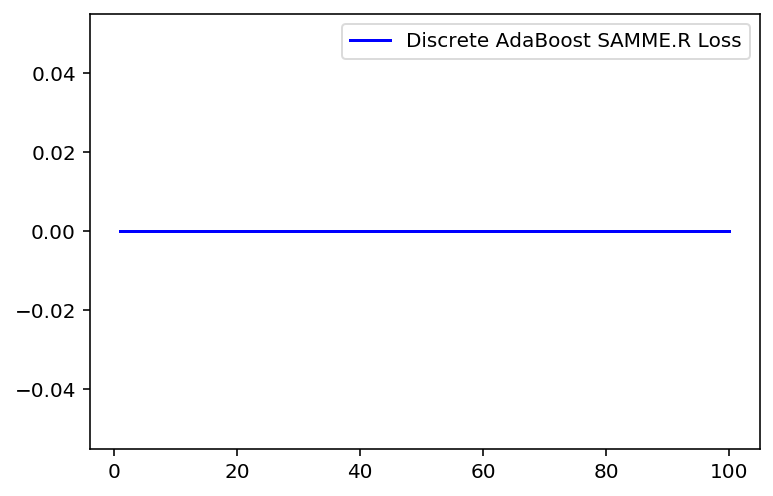

Scoring classifier
Accuracy: 0.372212197227667
Confusion matrix, without normalization
[[22656  9581  9971  9337  4458]
 [12621 20274  8365  5794  5004]
 [12898  7788 16295  8723  9669]
 [12901  5494  9609 19036  7521]
 [ 5926  4510 10984  8274 22192]]
Normalized confusion matrix for classifier
[[0.4  0.17 0.18 0.17 0.08]
 [0.24 0.39 0.16 0.11 0.1 ]
 [0.23 0.14 0.29 0.16 0.17]
 [0.24 0.1  0.18 0.35 0.14]
 [0.11 0.09 0.21 0.16 0.43]]
--------------------


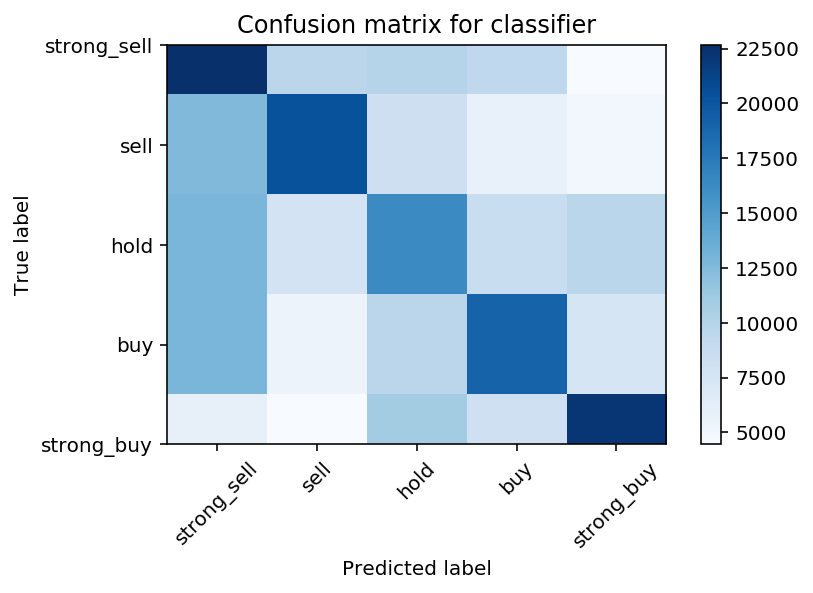

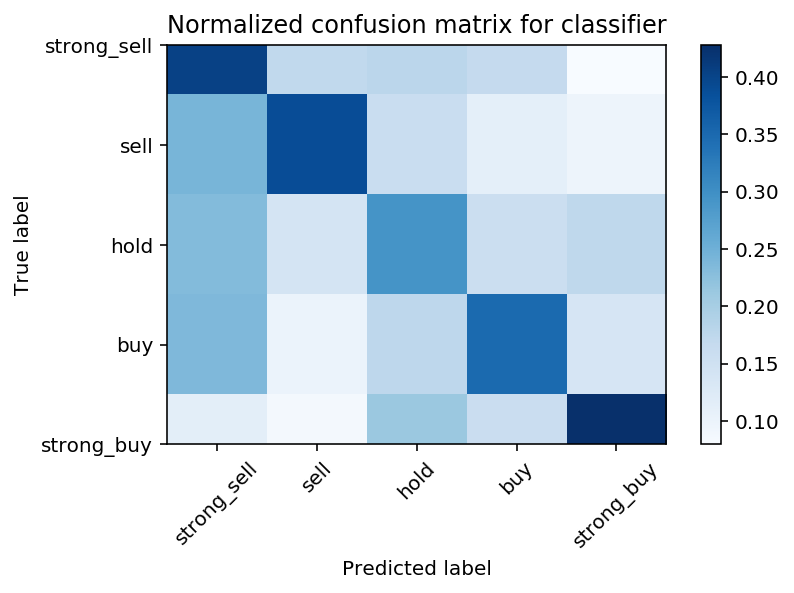

In [15]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import zero_one_loss

#Adaboost
adaboost_model = AdaBoostClassifier(
    ExtraTreesClassifier(), 
    n_estimators=100,
    algorithm='SAMME.R'
)

print('-' * 50)
print('Fitting adaboost model')
adaboost_model.fit(sample_train_data, sample_train_target_le)
print('-' * 50)
print('Saving model')
joblib.dump(adaboost_model, 'models/adaboost-model-2.joblib.z')
print('Adaboost model done')

fig = plt.figure()

ada_discrete_err_train = np.zeros((adaboost_model.n_estimators,))
for i, y_pred in enumerate(adaboost_model.staged_predict(sample_train_data)):
    ada_discrete_err_train[i] =  zero_one_loss(y_pred, sample_train_target_le.values)
    
plt.plot(np.arange(adaboost_model.n_estimators) + 1, ada_discrete_err_train,
        label='Discrete AdaBoost SAMME.R Loss',
        color='blue')

leg = plt.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()

train_pred_y = adaboost_model.predict(sample_test_data)
evaluate_classifier(sample_test_target_le.values, train_pred_y, bin_names)


In [ ]:
from sklearn.metrics import zero_one_loss

#Adaboost
adaboost_model = AdaBoostClassifier(
    RandomForestClassifier(
        max_depth=20, 
        n_estimators=505, 
        min_samples_split=2, 
        min_samples_leaf=1), 
    n_estimators=20,
    algorithm='SAMME.R'
)

print('-' * 50)
print('Fitting adaboost model')
adaboost_model.fit(agg_model_third.transform(sample_train_data), sample_train_target_le)
print('-' * 50)
print('Saving model')
joblib.dump(adaboost_model, 'models/adaboost-model.joblib.z')
print('Adaboost model done')

fig = plt.figure()

ada_discrete_err_train = np.zeros((adaboost_model.n_estimators,))
for i, y_pred in enumerate(adaboost_model.staged_predict(agg_model_third.transform(sample_train_data))):
    ada_discrete_err_train[i] =  zero_one_loss(y_pred, sample_train_target_le.values)
    
plt.plot(np.arange(adaboost_model.n_estimators) + 1, ada_discrete_err_train,
        label='Discrete AdaBoost SAMME.R Loss',
        color='blue')

leg = plt.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()

train_pred_y = adaboost_model.predict(agg_model_third.transform(sample_test_data))
evaluate_classifier(sample_test_target_le.values, train_pred_y, bin_names)


--------------------------------------------------
Fitting histogram model
Binning 2.384 GB of data: 14.864 s
Fitting gradient boosted rounds:
[1/343] 5 trees, 3115 leaves (623 on avg), max depth = 24, in 18.799s
[2/343] 5 trees, 3115 leaves (623 on avg), max depth = 26, in 27.766s
[3/343] 5 trees, 3115 leaves (623 on avg), max depth = 27, in 21.346s
[4/343] 5 trees, 3115 leaves (623 on avg), max depth = 32, in 26.220s
[5/343] 5 trees, 3115 leaves (623 on avg), max depth = 25, in 16.270s
[6/343] 5 trees, 3115 leaves (623 on avg), max depth = 25, in 22.858s
[7/343] 5 trees, 3115 leaves (623 on avg), max depth = 25, in 17.289s
[8/343] 5 trees, 3115 leaves (623 on avg), max depth = 24, in 21.195s
[9/343] 5 trees, 3115 leaves (623 on avg), max depth = 25, in 17.290s
[10/343] 5 trees, 3115 leaves (623 on avg), max depth = 29, in 20.250s
[11/343] 5 trees, 3115 leaves (623 on avg), max depth = 26, in 18.440s
[12/343] 5 trees, 3115 leaves (623 on avg), max depth = 30, in 18.431s
[13/343] 5 tre

[115/343] 5 trees, 3115 leaves (623 on avg), max depth = 34, in 19.316s
[116/343] 5 trees, 3115 leaves (623 on avg), max depth = 37, in 11.915s
[117/343] 5 trees, 3115 leaves (623 on avg), max depth = 34, in 17.788s
[118/343] 5 trees, 3115 leaves (623 on avg), max depth = 39, in 13.695s
[119/343] 5 trees, 3115 leaves (623 on avg), max depth = 34, in 17.158s
[120/343] 5 trees, 3115 leaves (623 on avg), max depth = 35, in 13.987s
[121/343] 5 trees, 3115 leaves (623 on avg), max depth = 35, in 15.963s
[122/343] 5 trees, 3115 leaves (623 on avg), max depth = 30, in 14.941s
[123/343] 5 trees, 3115 leaves (623 on avg), max depth = 32, in 15.641s
[124/343] 5 trees, 3115 leaves (623 on avg), max depth = 34, in 15.498s
[125/343] 5 trees, 3115 leaves (623 on avg), max depth = 35, in 14.603s
[126/343] 5 trees, 3115 leaves (623 on avg), max depth = 34, in 17.030s
[127/343] 5 trees, 3115 leaves (623 on avg), max depth = 34, in 13.796s
[128/343] 5 trees, 3115 leaves (623 on avg), max depth = 35, in 

[229/343] 5 trees, 3115 leaves (623 on avg), max depth = 34, in 15.098s
[230/343] 5 trees, 3115 leaves (623 on avg), max depth = 35, in 14.794s
[231/343] 5 trees, 3115 leaves (623 on avg), max depth = 40, in 16.083s
[232/343] 5 trees, 3115 leaves (623 on avg), max depth = 30, in 14.249s
[233/343] 5 trees, 3115 leaves (623 on avg), max depth = 34, in 16.616s
[234/343] 5 trees, 3115 leaves (623 on avg), max depth = 39, in 13.064s
[235/343] 5 trees, 3115 leaves (623 on avg), max depth = 35, in 19.496s
[236/343] 5 trees, 3115 leaves (623 on avg), max depth = 35, in 12.142s
[237/343] 5 trees, 3115 leaves (623 on avg), max depth = 38, in 19.174s
[238/343] 5 trees, 3115 leaves (623 on avg), max depth = 34, in 12.085s
[239/343] 5 trees, 3115 leaves (623 on avg), max depth = 35, in 17.388s
[240/343] 5 trees, 3115 leaves (623 on avg), max depth = 39, in 13.447s
[241/343] 5 trees, 3115 leaves (623 on avg), max depth = 40, in 17.001s
[242/343] 5 trees, 3115 leaves (623 on avg), max depth = 47, in 

[343/343] 5 trees, 3115 leaves (623 on avg), max depth = 40, in 12.701s
Fit 1715 trees in 5539.600 s, (1068445 total leaves)
Time spent computing histograms: 3693.183s
Time spent finding best splits:  951.011s
Time spent applying splits:      480.925s
Time spent predicting:           4.496s
--------------------------------------------------
Saving model
Histogram model done
Scoring classifier
Accuracy: 0.43866741267447507
Confusion matrix, without normalization
[[22506  7689 10978  9947  4883]
 [ 9887 22245  8836  5686  5404]
 [ 9639  5061 20153  8827 11693]
 [ 9735  3092  8938 24286  8510]
 [ 2672  2106 10505  7405 29198]]
Normalized confusion matrix for classifier
[[0.4  0.14 0.2  0.18 0.09]
 [0.19 0.43 0.17 0.11 0.1 ]
 [0.17 0.09 0.36 0.16 0.21]
 [0.18 0.06 0.16 0.45 0.16]
 [0.05 0.04 0.2  0.14 0.56]]
--------------------


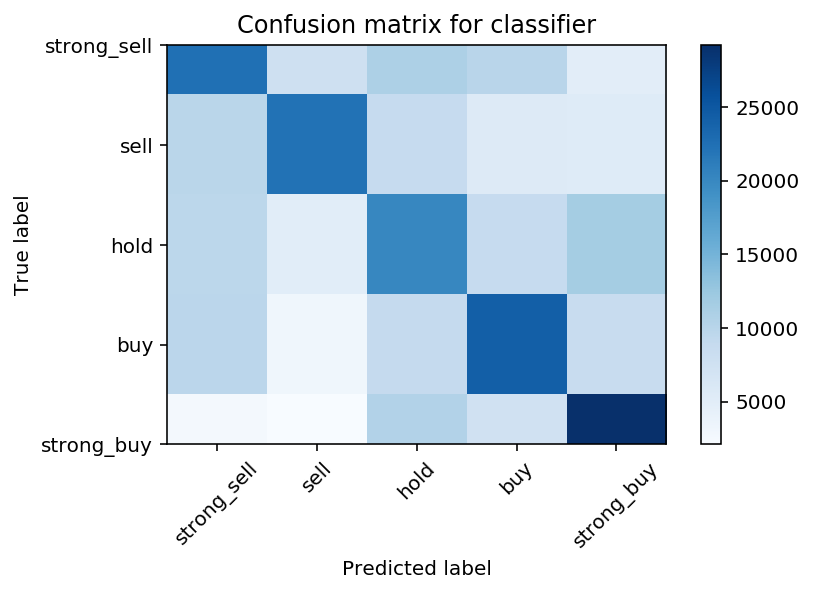

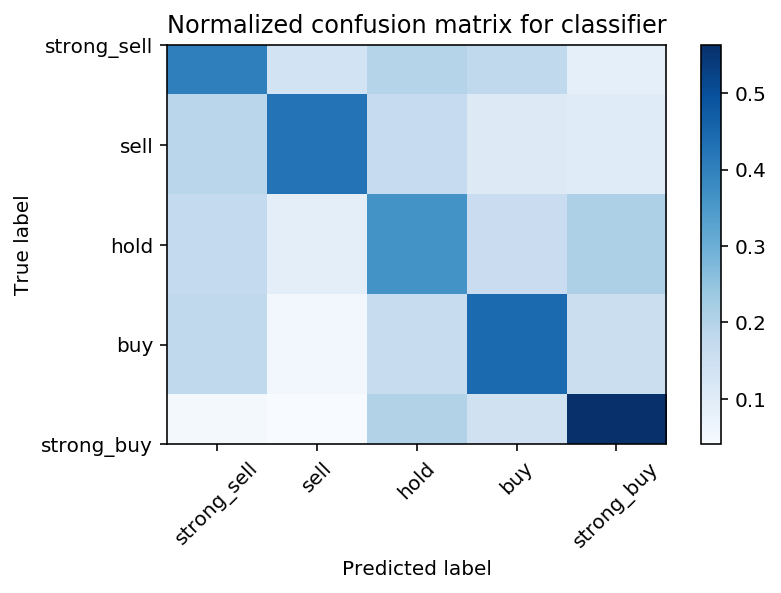

In [16]:
histogram_model = HistGradientBoostingClassifier(
    max_iter=343, 
    max_leaf_nodes=623, 
    learning_rate=0.1, 
    min_samples_leaf=2, 
    l2_regularization=0.,
    verbose=1
)
    
print('-' * 50)
print('Fitting histogram model')
histogram_model.fit(sample_train_data, sample_train_target_le)
print('-' * 50)
print('Saving model')
joblib.dump(histogram_model, 'models/histogram-model.joblib.z')
print('Histogram model done')

train_pred_y = histogram_model.predict(sample_test_data)
evaluate_classifier(sample_test_target_le.values, train_pred_y, bin_names)


In [ ]:
voting_model = EnsembleVoteClassifier(
    clfs=[random_forest_model, adaboost_model, histogram_model], 
    voting='soft',
    refit=False,
    verbose=1)

print('Fitting voting classifier')
voting_model.fit(sample_train_data, sample_train_target_le)
print('-' * 50)
print('Saving model')
joblib.dump(voting_model, 'models/voting-model.joblib.z')
print('Voting classifier done')


In [ ]:
# Execute backtest
# del test_x, test_y_le, test_symbols
train_pred_y = voting_model.predict(train_data)
evaluate_classifier(train_target_le.values, train_pred_y, bin_names)
